In [16]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


/home/eketerina753/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [18]:
data=pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [19]:
len(data)

284

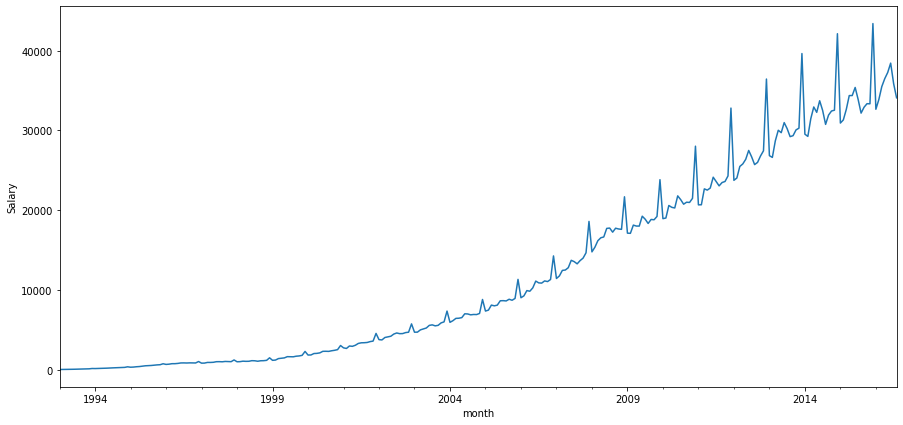

In [20]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

По графику видно, что ряд не стационарен, поскольку имеется выраженный тренд и годовая сезонность. Наблюдается возрастание дисперсии к концу ряда

### Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

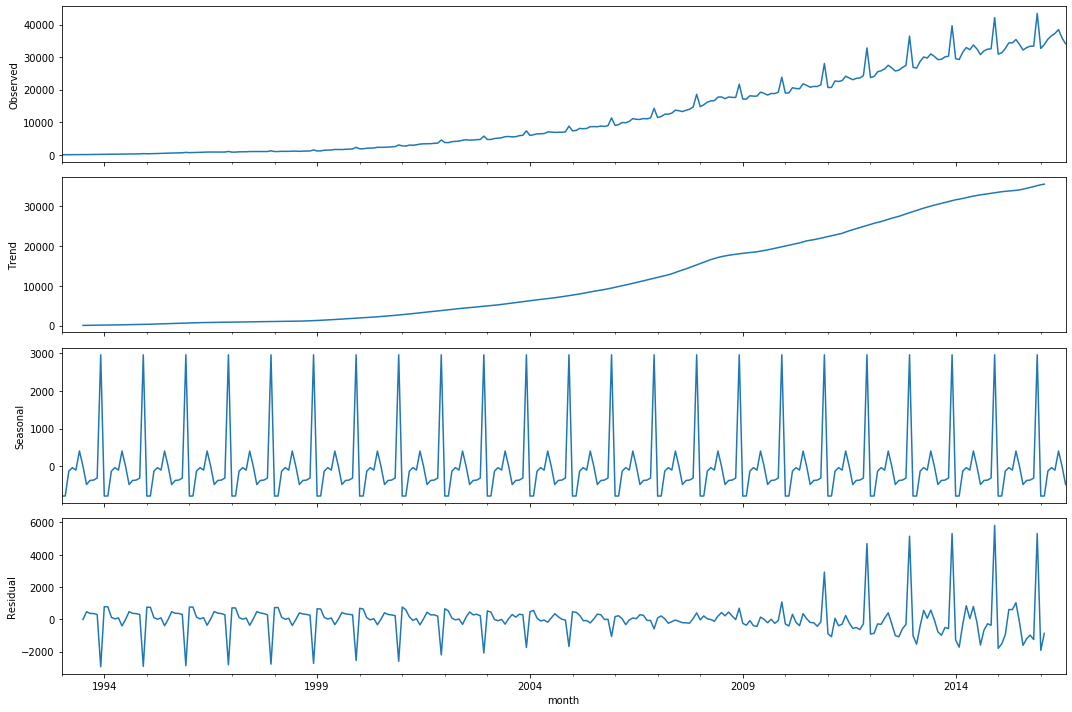

In [21]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

=> нельзя отвергнуть гипотезу о нестационарности ряда

### Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


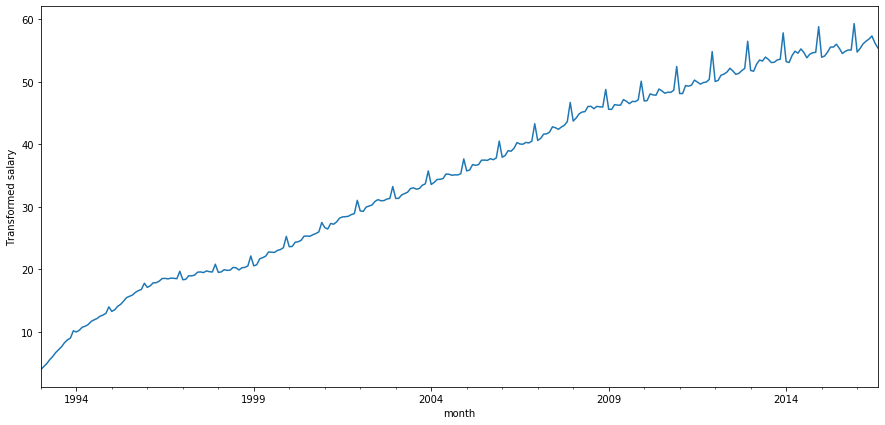

In [22]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

=> гипотезу о нестационарности ряда все еще нельзя отвергнуть

### Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

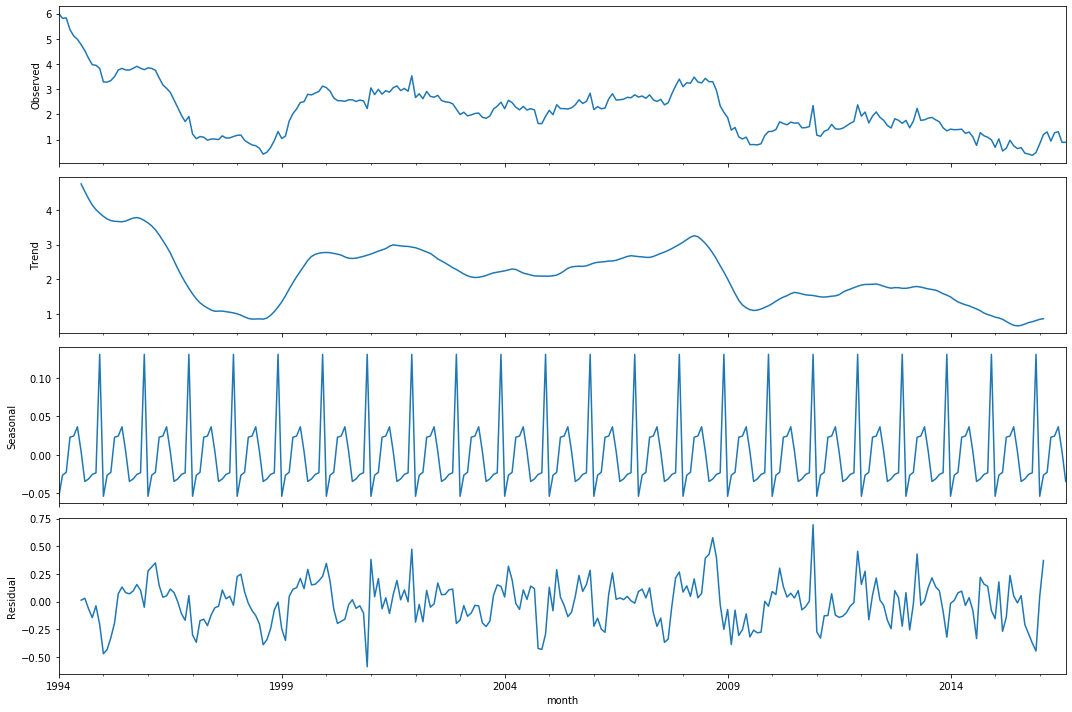

In [23]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
data.dropna(inplace=True)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff)[1])

=> ряд стационарен по критерию Дики-Фуллера, однако при визуальном анализе видно, что от тренда до конца избаться не удалось, пожтому применим обычное дифференцирование к ряду:


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

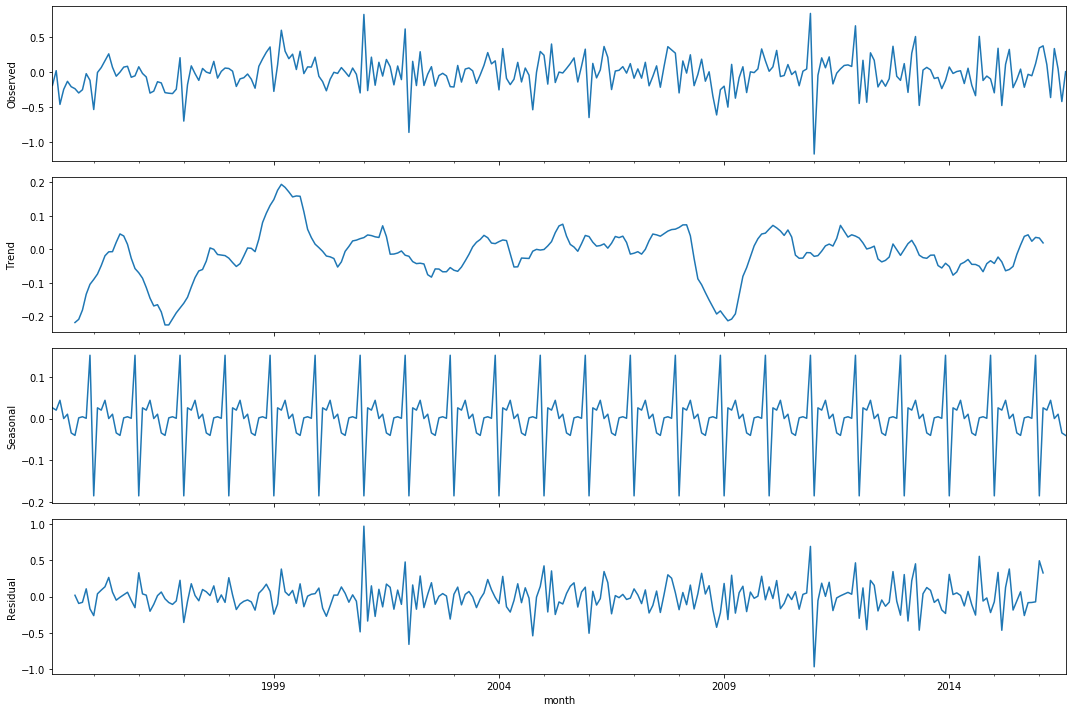

In [24]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
data.dropna(inplace=True)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2)[1])

=> ряд стационаре по критерию Дики-Фуллера, по графику видно, определенного тренда не наблюдается

### Посмотрим на ACF и PACF полученного ряда:

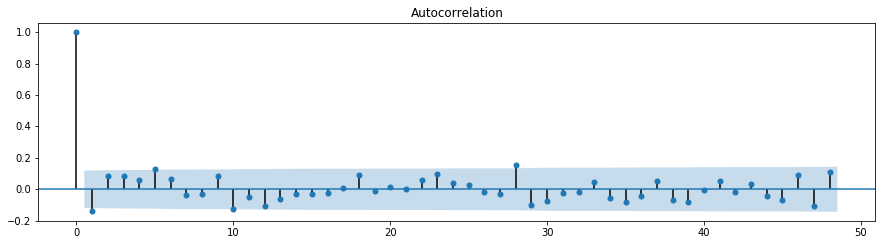

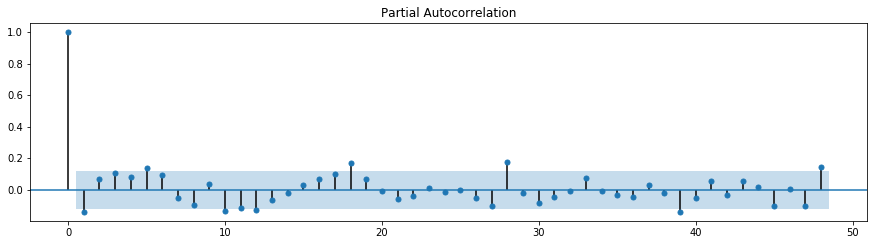

In [25]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2.values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2.values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=10, P=4, p=11

In [26]:
ps = range(0, 11)
d=1
qs = range(0, 10)
Ps = range(0, 4)
D=1
Q = 0

In [27]:
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

440

In [47]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, Q, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1h 27min 10s, sys: 24.6 s, total: 1h 27min 35s
Wall time: 48min 23s


In [52]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

    parameters        aic
221  (5, 5, 1) -22.054360
189  (4, 7, 1) -20.993416
182  (4, 5, 2) -20.767158
181  (4, 5, 1) -20.709521
88   (2, 2, 0) -20.542814


In [29]:
model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(5, d, 5), 
                                        seasonal_order=(1, D, Q, 12)).fit(disp=-1)

/home/eketerina753/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/eketerina753/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  271
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  23.027
Date:                            Mon, 15 Mar 2021   AIC                            -22.054
Time:                                    19:20:33   BIC                             20.581
Sample:                                02-01-1994   HQIC                            -4.910
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2676      0.229     -1.169      0.242      -0.716       0.181
ar.L2          0.1851      0.163   

Остатки модели:

Критерий Стьюдента: p=0.638077
Критерий Дики-Фуллера: p=0.000000


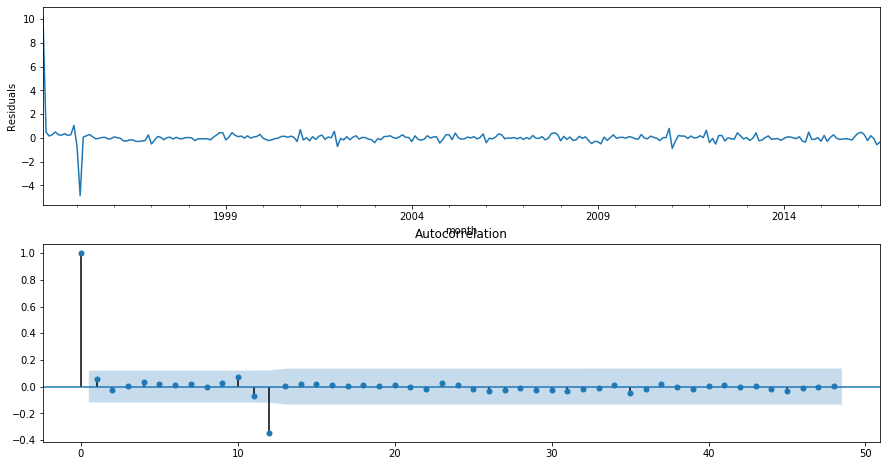

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model.resid)[1])

=> критерий Стьюдента не отвергает гипотезу о стационарности остататков модели, а критерий Дики-Фуллера подтверждает гипотезу о стационарности модели, что можно наблюдать визуально. Критерий Льюнга-Бокса подтверждает неавтокоррелированность остатков (p=0.86)

### Посмотрим, как построенная модель описывает данные:

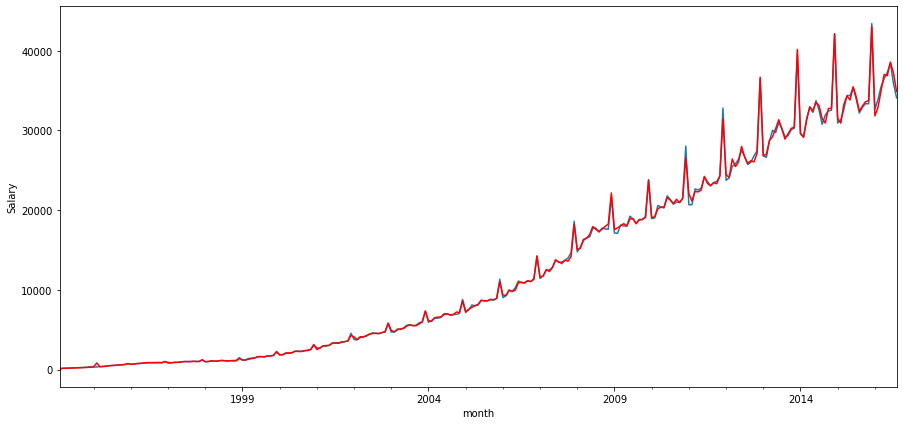

In [34]:
data['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model.plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз на два года

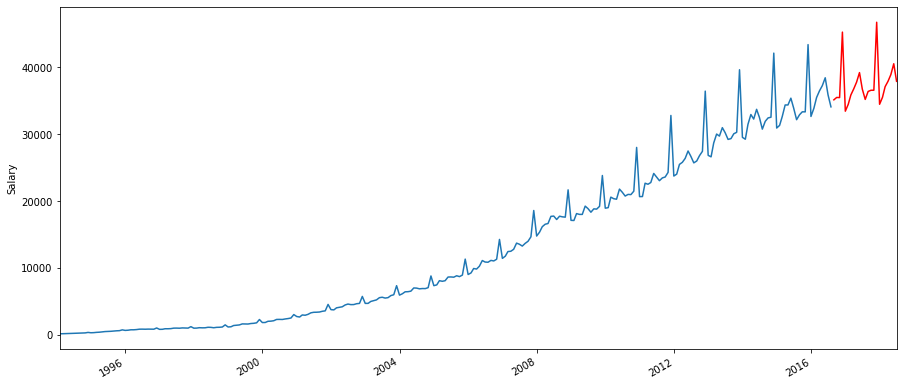

In [36]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(model.predict(start=len(data), end=len(data)+24), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

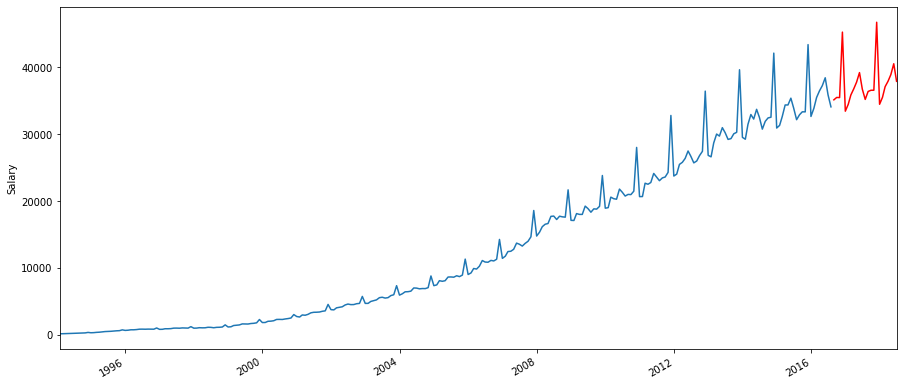

In [43]:
plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()